# ARIMA Model

We'll take a look at the ARIMA model which attempts to predict the value of 1 variable based off of the past.

## Installing and importing required libraries

In [30]:
import numpy as np
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error

Load the data

In [31]:
with open('../data/raw_data.pickle', 'rb') as f:
    data = pickle.load(f)

In [32]:
with open('../data/train_data.pickle', 'rb') as f:
    train_data = pickle.load(f)

Take a look at the data

In [33]:
data

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


Only interested in the pollution as the ARIMA model only takes one variable. Want to visualise what the pollution data looks like

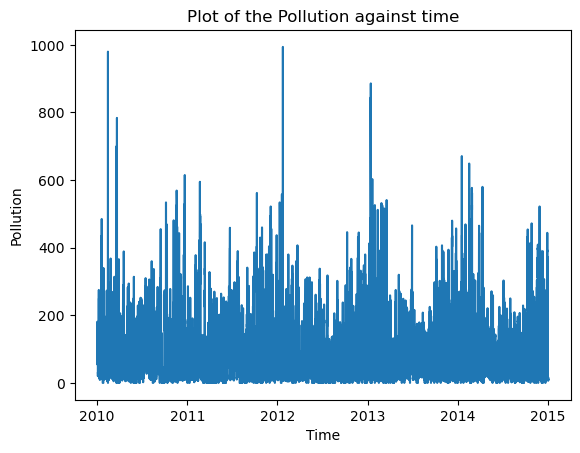

In [34]:
variable_of_interest = data['pollution']


plt.plot(variable_of_interest)
plt.title('Plot of the Pollution against time')
plt.xlabel('Time')
plt.ylabel('Pollution')
plt.show()

Taking a look at the correlation graphs for the pollution variable so we can decide how many lags we need to include

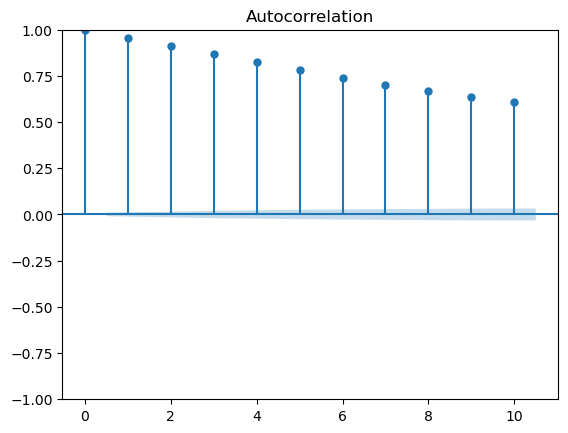

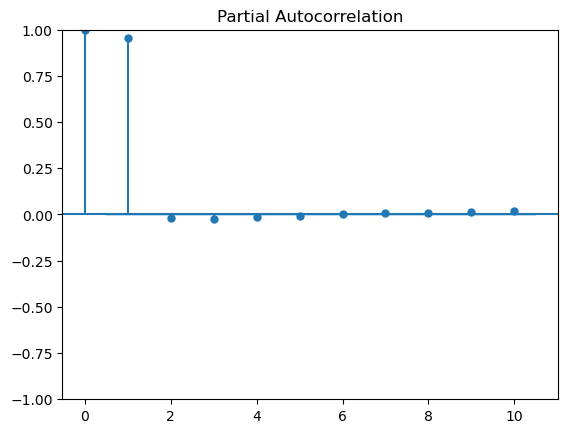

In [35]:
plot_acf(data['pollution'].dropna(), lags=10)
plt.show()

plot_pacf(data['pollution'].dropna(), lags=10)
plt.show()

Seems only the previous value has any real impact so we can take p = 1

Create training and test splits

In [49]:
train_size = int(len(train_data) * 0.999)
train_df1 = train_data[:train_size]
val_df = train_data[train_size:]
train_df2 = train_df1[['pollution']]


In [50]:
train_df2

,pollution
date,
2010-01-02 00:00:00,0.129779
2010-01-02 01:00:00,0.148893
2010-01-02 02:00:00,0.159960
2010-01-02 03:00:00,0.182093
2010-01-02 04:00:00,0.138833
...,...
2014-06-30 15:00:00,0.074447
2014-06-30 16:00:00,0.072435
2014-06-30 17:00:00,0.051308


In [55]:
model = ARIMA(train_df2, order=(1, 0, 1))
arima_model = model.fit()

c:\Users\djjjo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\djjjo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\djjjo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              pollution   No. Observations:                39380
Model:                 ARIMA(1, 0, 1)   Log Likelihood               84994.839
Date:                Thu, 21 Nov 2024   AIC                        -169981.678
Time:                        09:56:08   BIC                        -169947.354
Sample:                    01-02-2010   HQIC                       -169970.805
                         - 06-30-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0951      0.004     23.930      0.000       0.087       0.103
ar.L1          0.9529      0.001    972.417      0.000       0.951       0.955
ma.L1          0.0120      0.001     12.328      0.0

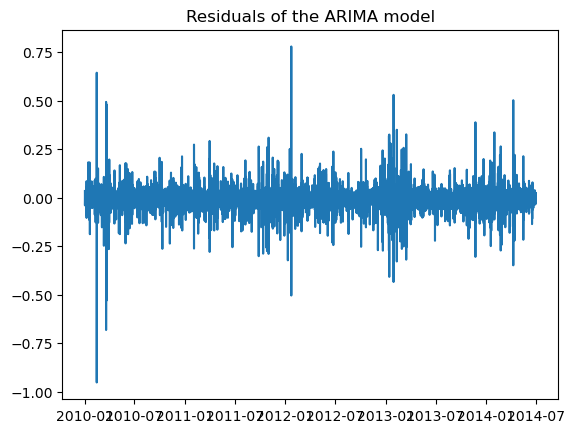

In [56]:
print(arima_model.summary())
residuals = arima_model.resid
plt.plot(residuals)
plt.title("Residuals of the ARIMA model")
plt.show()

In [57]:
forecast = arima_model.forecast(steps=len(val_df))
forecast

2014-06-30 20:00:00    0.042633
2014-06-30 21:00:00    0.045104
2014-06-30 22:00:00    0.047459
2014-06-30 23:00:00    0.049702
2014-07-01 00:00:00    0.051840
2014-07-01 01:00:00    0.053877
2014-07-01 02:00:00    0.055818
2014-07-01 03:00:00    0.057668
2014-07-01 04:00:00    0.059430
2014-07-01 05:00:00    0.061110
2014-07-01 06:00:00    0.062710
2014-07-01 07:00:00    0.064235
2014-07-01 08:00:00    0.065687
2014-07-01 09:00:00    0.067072
2014-07-01 10:00:00    0.068391
2014-07-01 11:00:00    0.069648
2014-07-01 12:00:00    0.070846
2014-07-01 13:00:00    0.071987
2014-07-01 14:00:00    0.073074
2014-07-01 15:00:00    0.074110
2014-07-01 16:00:00    0.075098
2014-07-01 17:00:00    0.076039
2014-07-01 18:00:00    0.076935
2014-07-01 19:00:00    0.077789
2014-07-01 20:00:00    0.078603
2014-07-01 21:00:00    0.079379
2014-07-01 22:00:00    0.080118
2014-07-01 23:00:00    0.080822
2014-07-02 00:00:00    0.081493
2014-07-02 01:00:00    0.082132
2014-07-02 02:00:00    0.082741
2014-07-

In [58]:
mse = mean_squared_error(val_df["pollution"], forecast)
rmse = np.sqrt(mse)
print(f"RMSE on validation set: {rmse}")

RMSE on validation set: 0.041199377609662406


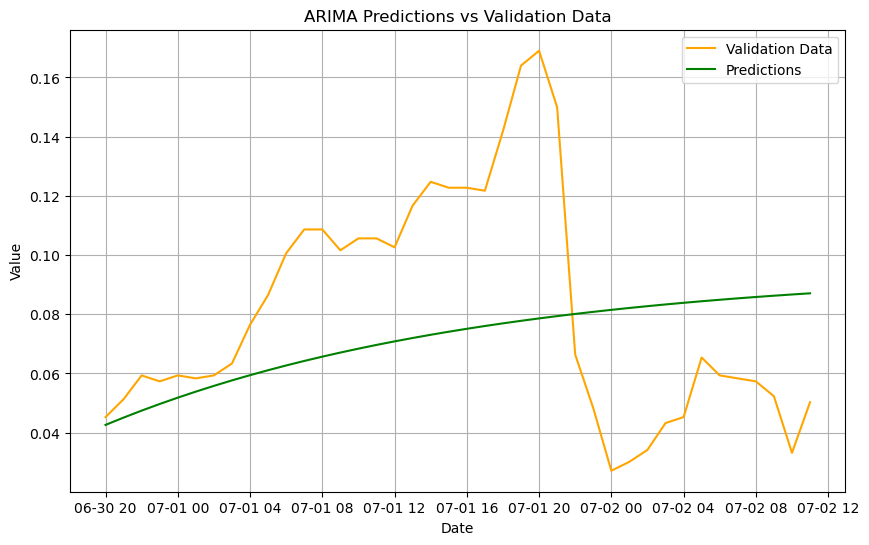

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(val_df["pollution"], label='Validation Data', color='orange')
plt.plot(val_df.index, forecast, label='Predictions', color='green')

plt.title('ARIMA Predictions vs Validation Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-169506.387, Time=3.50 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-47067.814, Time=3.27 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-169508.988, Time=3.79 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-90386.404, Time=6.30 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-169506.991, Time=3.70 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-169506.990, Time=3.48 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-169505.334, Time=32.96 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-169978.479, Time=10.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-75153.464, Time=12.84 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-169981.913, Time=19.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-169998.101, Time=8.35 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-170002.751, Time=13.06 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-170002.352, Time=25.78 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-169982.974, Ti

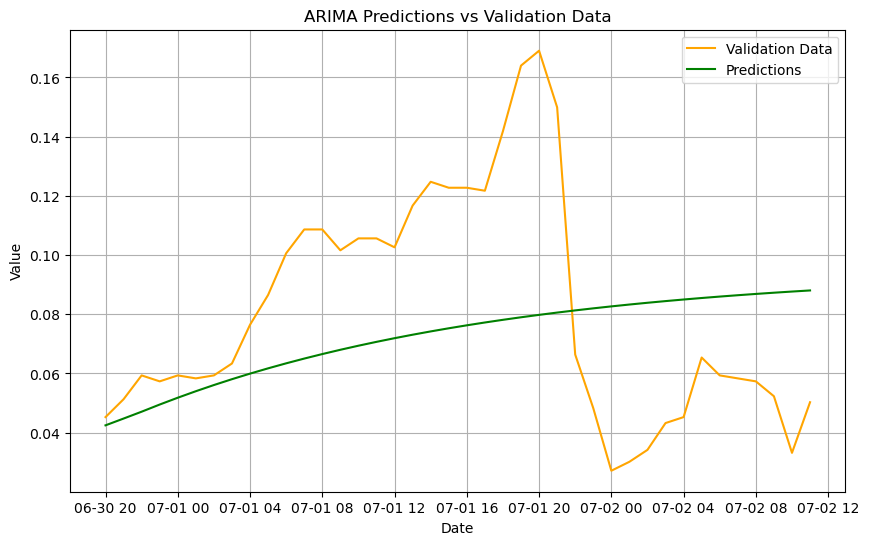

In [60]:
from pmdarima import auto_arima

# Fit the best ARIMA model automatically
auto_model = auto_arima(train_df2, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

# Forecast for the next len(val_df) steps
forecast_auto = auto_model.predict(n_periods=len(val_df))

# Print forecast
print(forecast_auto)

plt.figure(figsize=(10, 6))
plt.plot(val_df["pollution"], label='Validation Data', color='orange')
plt.plot(val_df.index, forecast_auto, label='Predictions', color='green')

plt.title('ARIMA Predictions vs Validation Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
result = adfuller(train_df2)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -19.553679398426006
p-value: 0.0
